In [1]:
import pandas as pd
from typing import List, Dict, Any
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# Data description

To examine the evidence, we begin by assembling the key ingredients of our analysis using two official datasets from the **Swiss Federal Statistical Office (FSO)**:<br>
(1) Jobs by economic division, employment level and sex (restaurant sector, quarterly, by gender), and<br>
(2) Permanent resident population by year and sex, from which we extract the working-age population by gender.<br><br>
Throughout the analysis, the restaurant sector is defined according to the official Swiss **NOGA classification**, which includes restaurants, cafés, catering services and similar food-service activities.
### The outcome variable
We measure labour market outcomes using the **Employment-to-population Ratio** in percent in the catering sector, computed quarterly between **2010Q1 and 2024Q4**, separately for women and men. Employment figures in restauration are drawn from the FSO employment statistics by economic division, gender and quarter, while population counts by gender and year are taken from the permanent resident population statistics and restricted to the **population in working age**. 
The Employment-to-population Ratio is constructed as follows:
$$\text{Employment-to-population}_{g, t, q} = \frac{\text{Employment}^{catering}_{g, t, q}}{\text{Working-age population}_{g, t}}$$

where g denotes gender (Female, Male), t the year, and q the quarter.<br><br>
This ratio measures the share of the working-age population employed in the restaurant sector. We use this indicator rather than raw employment levels in order to make employment outcomes comparable across genders and over time, independently of demographic differences. It also provides a clear interpretation in percentage points, which is particularly suited for analysing changes before and after the COVID-19 shock. 

### Independent variables: Control and treatment periods
The key independent variable captures exposure to the COVID-19 shock through a time-based classification of the sample into three distinct periods.<br><br>
We define:
- **Before Lockdown:** Pre-COVID period from 2010Q1 to 2019Q4, which serves as the baseline control period;
- **During Lockdown:** COVID period from 2020Q1 to 2022Q2,corresponding to the phase of mandatory closures and severe restrictions affecting restaurant activity. This period ends in 2022Q2, as all remaining federal COVID-19 measures affecting restaurants were lifted on April 1, 2022, marking the full reopening of the sector;
- **After Lockdown:** Post-COVID period from 2022Q3 to 2024Q4, capturing the period following the full reopening of restaurants on April 1, 2022, and allowing us to study persistence and recovery dynamics.<br>

These three periods structure the treatment intensity over time: the pre-COVID period represents the untreated baseline, the lockdown period captures the immediate shock, and the post-lockdown period reflects potential recovery or long-lasting effects.

### Treatment and control groups
Gender defines the two comparison groups. A binary indicator Female is used, equal to 1 for women and 0 for men.
- **Women** constitute the **treatment group**.
- **Men** serve as the control **group**.

### No Controls variables 
Our analysis focuses exclusively on the restaurant sector. As a result, we do not include additional control variables such as occupation, teleworkability, or technological exposure. This choice is deliberate.<br><br>
Firstly, all observations belong to the same industry and are observed at the same time frequency, which already limits sectoral and institutional heterogeneity. More importantly, our analysis compares employment outcomes for women and men **within the same sector and over the same time periods**, which absorbs many confounding factors common to both groups.<br><br>
Secondly, introducing additional controls could generate **post-treatment bias**, as many potential control variables (such as working hours, job type, or employment arrangements) may themselves be affected by the COVID-19 shock. In this context, excluding such controls helps preserve a clearer interpretation of the estimated effects.<br><br>
Finally, the restaurant sector remains highly dependent on physical presence and face-to-face interaction, and has been only marginally affected by recent technological shocks such as the diffusion of generative AI. The absence of these controls is therefore unlikely to represent a major source of omitted-variable bias in our setting.

## Time fixed effect
Additionally, we incorporate **time fixed effects** to account for unobserved factors that vary over time but are common to all observations in our dataset. In particular, we include **quarter fixed effects (Q1–Q4)** to control recurring seasonal patterns in restaurant activity.<br><br>
Examples of such time-varying factors include:
- Seasonal fluctuations in restaurant demand (e.g. higher attendan§ce during summer months) like changes in tourism intensity across the year or holiday periods/ school vacations,
- Weather-related effects that systematically influence eating-out behaviour.

By controlling for these predictable seasonal patterns, quarter fixed effects ensure that our estimates are not driven by regular fluctuations in restaurant activity, but rather capture differences related to the COVID-19 shock and gender-specific employment dynamics.

## Data Bias and Limitations
As with any recipe, even carefully selected ingredients come with imperfections; accordingly, several limitations and potential biases should be acknowledged.
- **Timing of COVID-19 policies:** Major restrictions began in mid-March 2020, meaning that 2020Q1 combines pre- and post-lockdown weeks. We nevertheless classify 2020Q1 as part of the lockdown period, as employment-to-population ratios already decline visibly during this quarter.
- **Policy granularity:** Our policy indicators do not distinguish between different phases of reopening. Measures such as capacity limits or QR-code requirements are folded into broader lockdown periods, potentially masking variation in restriction intensity.
- **Population data frequency:** Population data are available only annually. When computing quarterly employment-to-population ratios, we assume a constant working-age population within each year. Given Switzerland’s slow demographic changes, this approximation is unlikely to materially affect the results.
- **Occupational detail:** The data do not allow us to distinguish between different occupations within the restaurant sector. In particular, we cannot separately identify managerial and non-managerial positions. This may matter if managers followed different employment trajectories or were more exposed to emerging technologies such as generative AI. We therefore assume that managerial positions represent only a small share of total restaurant employment. This assumption is supported by international evidence based on ILOSTAT data, which documents the distribution of tourism employment by occupation including restaurant-related activities. This shows that managerial positions account for approximately 7–10% of total employment, for both women and men. Even if this evidence is drawn from international data, it nevertheless remains informative for our analysis, as it captures structural features of the restaurant sector that are highly comparable across countries such as Switzerland. As a result, any bias arising from this limitation is likely to be limited.

Taken together, these limitations call for caution in interpretation but do not undermine the core identification strategy.

In [2]:
def restauration_employement_to_population_ratio(url_catering : str, url_population : str) -> pd.DataFrame:
    """Retrieve the data from the URLs and create the DataFrame with the Year, Quarter, Employment-to-population Ratio [%], and Female columns.<br>
    - Year: values from 2010 to 2024.<br>
    - Quarter: Values from 1 to 4.<br>
    - Employment-to-population Ratio [%]: The result of the division of the number of employment (per gender, each quarter) by the number of people in
    the working age(15+y.o, per gender, each year), in percentage.<br>
    - Female: Dummy variable (1 if Female, 0 if Male)

    :param url_catering: The URL to download the catering data
    :type url_catering: str
    :param url_population: The URL to download the population data
    :type url_population: str

    :return: The DataFrame with the Year, Quarter, Employment-to-population Ratio [%], and Female columns.
    :rtype: pd.DataFrame
    """
    df_restauration = pd.read_csv(url_catering, encoding="ANSI")
    df_population = pd.read_csv(url_population, encoding="ANSI")
    df_population = df_population.groupby(["Année", "Sexe"], as_index=False)["Effectif au 1er janvier"].agg("sum")
    
    years : List[int] = [i for i in range(2010, 2025) for _ in range(8)]
    quarters : List[int] = [i for _ in range(15*2) for i in range(1, 5)]
    female : List[int] = [i for _ in range(15) for i in [1]*4+[0]*4]  # 1 if female, 0 if male
    indexes_of_columns_to_go : List[int] = [2+i for j in range((df_restauration.shape[1]-3)//4) for _ in range(2) for i in range(4*j+1, 4*j+5)] #to search efficiently in the dataframe for having the final dataframe in the right format easily
    y : List[float] = []

    for index, gender, year in zip(indexes_of_columns_to_go, female, years):
        y.append(df_restauration.iloc[gender, index]/df_population.loc[df_population["Année"].eq(year)&df_population["Sexe"].eq("Femme" if gender==1 else "Homme"), "Effectif au 1er janvier"].iat[0]*100)

    dict : Dict[List[Any]] = {"Year" : years,
            "Quarter" : quarters,
            "Employment-to-population Ratio [%]" : y, 
            "Female" : female}
    return pd.DataFrame(dict)

def create_quarter_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the columns with the dummy values for the Quarters (Q1, Q2, Q3 & Q4)

    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    quarter_lists_list = [[], [], [], []]
    for i in range(df.shape[0]):
        for j in range(1, 5):
            if df["Quarter"][i]==j:
                quarter_lists_list[j-1].append(1)
            else:
                quarter_lists_list[j-1].append(0)
    for i in range(4):
        df[f"Q{i+1}"]=quarter_lists_list[i]
    return df

def create_before_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the dummy value for the Before Lockdown values (1 if before 2020Q1 else 0)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    df["Before_Lockdown"] = [1 if i<80 else 0 for i in range(df.shape[0])]
    return df

def create_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the dummy value for the Lockdown values (1 if in [2020Q1, 2022Q2] else 0)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    indexes = [i for i in range(80, 98)]
    indexes.extend([100, 101])
    dummy_list = [1 if i in indexes else 0 for i in range(df.shape[0])]
    df["Lockdown"] = dummy_list
    return df

def create_after_lockdown_dummies(df: pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the dummy value for the After Lockdown values (1 if after 2022Q2 else 0)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    indexes_list = [98, 99]
    indexes_list.extend(i for i in range(102, df.shape[0]))
    dummy_list = [1 if i in indexes_list else 0 for i in range(df.shape[0])]
    df["After_Lockdown"] = dummy_list
    return df

def create_years_pre_post_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the columns with the dummy values for the period 2 and 1 year Before and After the Lockdown:<br>
    ([2018Q1,2018Q4], [2019Q1, 2019Q4], [2022Q3, 2023Q2], [2023Q3, 2024Q2])
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    oyb_dummies = [1 if 72<=i<80 else 0 for i in range(df.shape[0])]
    tyb_dummies = [1 if 64<=i<72 else 0 for i in range(df.shape[0])]
    oya_dummies = [1 if i in [98, 99, 102, 103, 104, 105, 108, 109] else 0 for i in range(df.shape[0])]
    tya_dummies = [1 if i in [106, 107, 110, 111, 112, 113, 114, 115] else 0 for i in range(df.shape[0])]
    df["Two_Years_Before"] = tyb_dummies
    df["One_Year_Before"] = oyb_dummies
    df["One_Year_After"] = oya_dummies
    df["Two_Years_After"] = tya_dummies
    return df

def time_dummy(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with year and quarter values merged (e,g:  2010Q1)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    df["time"] = df["Year"].astype(str) + "Q" + df["Quarter"].astype(str)
    return df

def quarter_number(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the number of the quarter (e,g: 2010Q1 = 0, 2024Q4 = 59)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    df["N_Quarter"] = (df["Year"] - df["Year"].min())*4 + (df["Quarter"] - 1)
    return df

def dataframe_creator(url_catering : str, url_population : str) -> pd.DataFrame:
    """Creat the DataFrame with all the necessary columns
    
    :param url_catering: The URL to download the catering data
    :type url_catering: str
    :param url_population: The URL to download the population data
    :type url_population: str
    :return: The DataFrame ready to be used.
    :rtype: pd.DataFrame
    """
    df = restauration_employement_to_population_ratio(url_catering, url_population)
    df = create_quarter_dummies(df)
    df = create_lockdown_dummies(df)
    df = create_after_lockdown_dummies(df)
    df = create_years_pre_post_dummies(df)
    df = time_dummy(df)
    df = quarter_number(df)
    return df

In [3]:
url_catering = "https://www.pxweb.bfs.admin.ch/sq/ac42fe01-72e8-4c55-9ab2-b997e87b1fa1"
url_population = "https://www.pxweb.bfs.admin.ch/sq/a2f3f03c-3b76-4dc0-890e-c6534d341848"

In [4]:
try:
    df = dataframe_creator(url_catering, url_population)
except Exception as e:
    df = pd.read_csv("df.csv")
df

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,Lockdown,After_Lockdown,Two_Years_Before,One_Year_Before,One_Year_After,Two_Years_After,time,N_Quarter
0,2010,1,3.103141,1,1,0,0,0,0,0,0,0,0,0,2010Q1,0
1,2010,2,3.084915,1,0,1,0,0,0,0,0,0,0,0,2010Q2,1
2,2010,3,3.088478,1,0,0,1,0,0,0,0,0,0,0,2010Q3,2
3,2010,4,2.990922,1,0,0,0,1,0,0,0,0,0,0,2010Q4,3
4,2010,1,2.482187,0,1,0,0,0,0,0,0,0,0,0,2010Q1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,4,2.456345,1,0,0,0,1,0,1,0,0,0,1,2024Q4,59
116,2024,1,2.452151,0,1,0,0,0,0,1,0,0,0,0,2024Q1,56
117,2024,2,2.494324,0,0,1,0,0,0,1,0,0,0,0,2024Q2,57
118,2024,3,2.441515,0,0,0,1,0,0,1,0,0,0,0,2024Q3,58


![DAG](DAG.png)
$$\text{Figure 1: Directed Acyclic Graph (DAG)}$$

# First hints/initial insights (data visualisation)
Before turning to causal identification strategies, we start by tasting the data. Just as a quick look at a menu gives a sense of what a restaurant has to offer, these descriptive patterns provide a first indication of whether the COVID-19 shock coincides with meaningful gender differences in employment in the catering sector.<br>

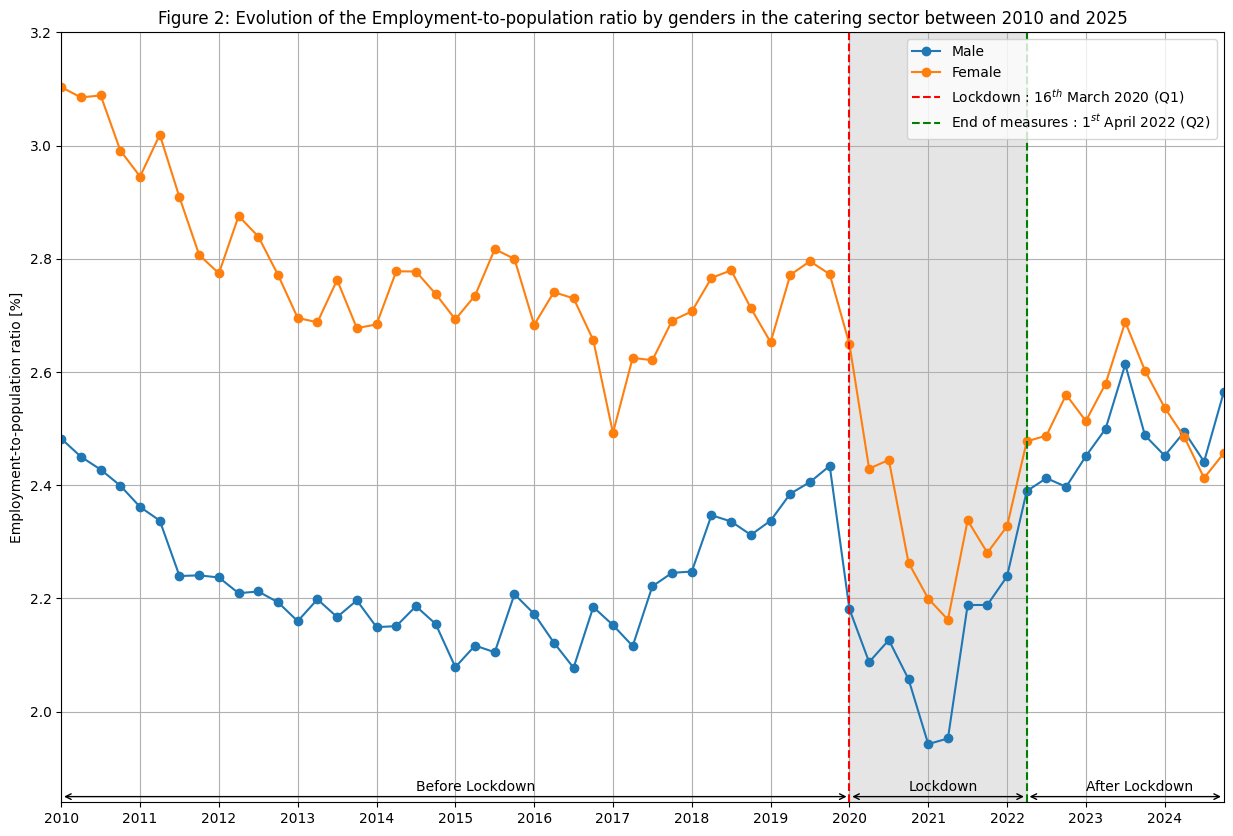

In [ ]:
def plot_ratio(df : pd.DataFrame) -> None:
    """Plot the evolution of the employement-to-population ratio for each gender
    
    :param df: The DataFrame with all the data
    :type df: pd.DataFrame"""
    time = np.linspace(0, 59, 60)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"], marker="o", label="Male")
    ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"], marker="o", label="Female")
    ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
    ax.axvline(49, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
    ax.axvspan(40, 49, color="grey", alpha=0.2)

    plt.annotate(text='', xy=(40,1.85), xytext=(0,1.85), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Before Lockdown', xy=(18,1.86), xytext=(18,1.86))
    plt.annotate(text='', xy=(49,1.85), xytext=(40,1.85), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Lockdown', xy=(43,1.86), xytext=(43,1.86))
    plt.annotate(text='', xy=(59,1.85), xytext=(49,1.85), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='After Lockdown', xy=(52,1.86), xytext=(52,1.86))

    plt.xlim(0, 59)
    plt.ylim(1.84, 3.2)
    plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
    plt.ylabel("Employment-to-population ratio [%]")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title("Figure 2: Evolution of the Employment-to-population ratio by genders in the catering sector between 2010 and 2025")
    plt.show()

plot_ratio(df)

The figure 2 shows the quarterly evolution of the employment-to-population ratio in the restaurant sector between 2010 and 2024, separately for women and men. Before 2020, both series display relatively stable and broadly parallel trends, with women consistently exhibiting a higher employment-to-population ratio than men. This suggests comparable pre-pandemic dynamics across genders within the sector. At the onset of the COVID-19 lockdown in early 2020, both series experienced a sharp decline, reflecting the immediate impact of containment measures on restaurant activity. While the contraction is substantial for both genders, it appears more pronounced for women. Following the lifting of restrictions, employment gradually recovers, but women’s employment-to-population ratio remains below its pre-pandemic trajectory for a longer period, pointing to a potentially uneven recovery.

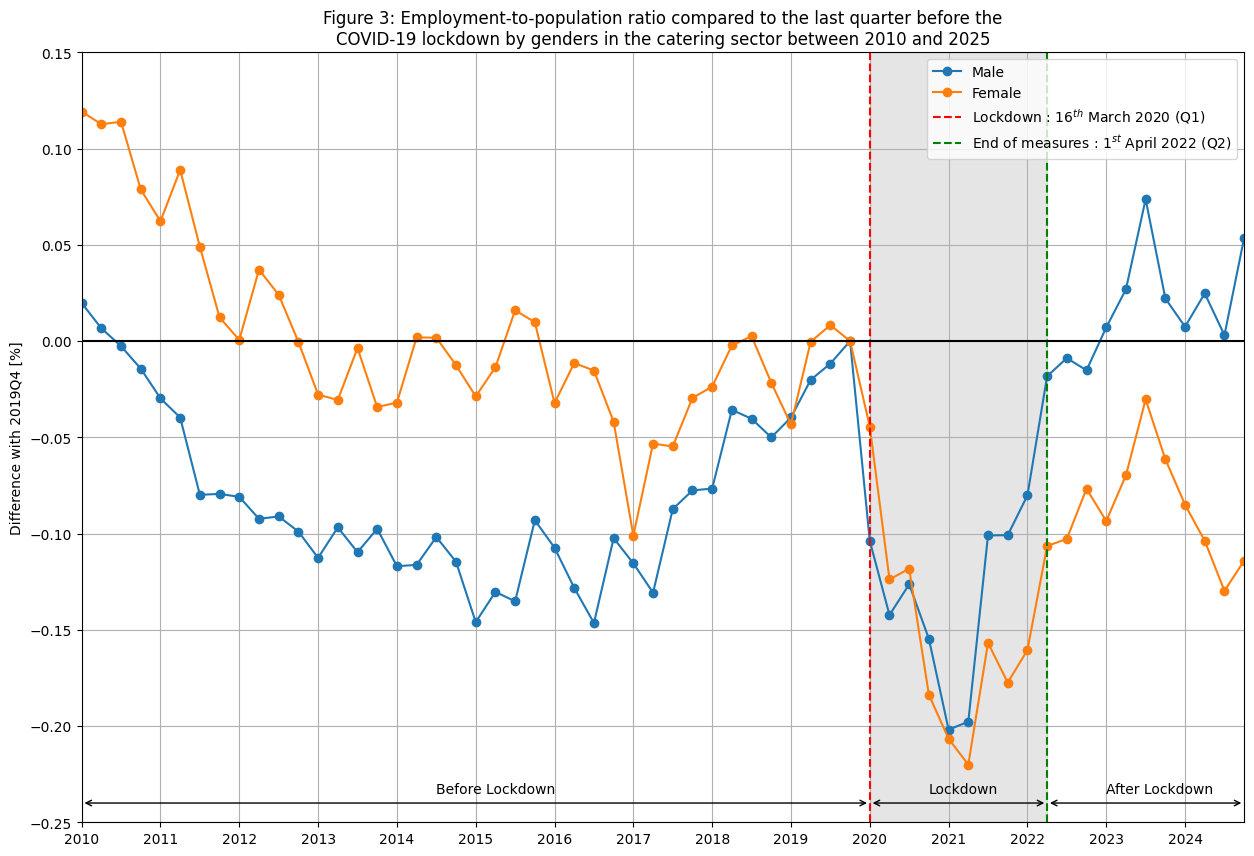

In [6]:
def plot_comparative(df : pd.DataFrame) -> None:
    """Plot the employement-to-population ratio compared to the last one before Lockdown for each gender
    
    :param df: The DataFrame with all the data
    :type df: pd.DataFrame"""
    before_covid_female = df.iloc[75, 2]
    before_covid_male = df.iloc[79, 2]
    time = np.linspace(0, 59, 60)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_male-1, marker="o", label="Male")
    ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_female-1, marker="o", label="Female")
    ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
    ax.axvline(49, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
    ax.axvspan(40, 49, color="grey", alpha=0.2)
    ax.hlines(0, xmin=0, xmax=59, color="k")

    plt.annotate(text='', xy=(40,-0.24), xytext=(0,-0.24), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Before Lockdown', xy=(18,-0.235), xytext=(18,-0.235))
    plt.annotate(text='', xy=(49,-0.24), xytext=(40,-0.24), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Lockdown', xy=(43,-0.235), xytext=(43,-0.235))
    plt.annotate(text='', xy=(59,-0.24), xytext=(49,-0.24), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='After Lockdown', xy=(52,-0.235), xytext=(52,-0.235))

    plt.xlim(0, 59)
    plt.ylim(-0.25, 0.15)
    plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
    plt.ylabel("Difference with 2019Q4 [%]")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title("Figure 3: Employment-to-population ratio compared to the last quarter before the\nCOVID-19 lockdown by genders in the catering sector between 2010 and 2025")
    plt.show()

plot_comparative(df)

The figure 3 complements this picture by expressing employment outcomes as deviations relative to the last pre-lockdown quarter (2019Q4). This normalization highlights both the magnitude and persistence of the shock. During the lockdown period, employment drops sharply for both men and women, with larger negative deviations for women at several points. Importantly, even after restrictions are lifted, women’s employment outcomes remain more negative relative to the pre-COVID benchmark, while men’s outcomes recover more quickly and, in some quarters, return closer to baseline levels. This divergence suggests that the pandemic may have widened the gender employment gap in the restaurant sector beyond the lockdown phase.<br><br>
Taken together, these first visual clues reveal three key flavours:
1. The COVID-19 shock coincides with a major disruption in restaurant employment for both genders.
2. Women appear to have been more adversely affected at the extensive margin.
3. Recovery paths differ, with signs of more persistent employment losses for women.

Like any first taste, these patterns do not establish causality. They do, however, set the table for the analysis that follows

# Cooking the main dish:
Moving to the main course of our empirical analysis, we rely on a difference-in-differences framework to guide our estimation strategy. This initial specification serves as our baseline regression and sets the stage for the analysis. We then extend this framework using an event-study design, which allows us to examine the temporal structure of the estimated effects.
## Placebo
Before starting to cook the main dish, the kitchen needs to be properly pre-heated to ensure reliable results. In empirical terms, this corresponds to verifying that the conditions for causal inference are met by assessing the parallel trends assumption, namely whether women and men followed comparable employment trends prior to the COVID-19 shock. To do so, we implement a placebo difference-in-differences regression using only pre-pandemic data. Specifically, we treat the period from 2017Q3 to 2019Q4 as a placebo post-period and compare it to an earlier pre-placebo period. The interaction between the female indicator and the placebo post period is statistically significant and negative, implying that women’s employment-to-population ratio was 0.10 percentage points lower than men’s during the placebo period. This result indicates a violation of the parallel trends assumption, suggesting that employment trajectories for women and men were already diverging prior to the COVID-19 shock. As a consequence, attributing the estimated effects in the main regressions entirely to the pandemic is challenging, since part of the observed differences may reflect pre-existing dynamics rather than the COVID-19 shock alone.

In [7]:
# restrict to pre-pandemic only (<= 2019Q4)
t_real = (2020 - df["Year"].min())*4  # 2020Q1
pre = df[df["N_Quarter"] < t_real].copy()

# Pick a placebo start date. Here: 2017Q3
t_placebo = (2014 - df["Year"].min())*4+2  # 2017Q3 -> 10 quarters long (same lenght as Covid-19: 2020Q1 to 2022Q2)
pre["PlaceboPost"] = (pre["N_Quarter"] >= t_placebo).astype(int)

formula_placebo = r"Q('Employment-to-population Ratio [%]') ~ Female + C(time) + Female:PlaceboPost"

m_placebo = smf.ols(formula_placebo, data=pre).fit(cov_type="HAC", cov_kwds={"maxlags": 4})

print(m_placebo.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.976
Model:                                                 OLS   Adj. R-squared:                  0.949
Method:                                      Least Squares   F-statistic:                 1.628e+04
Date:                                     Wed, 17 Dec 2025   Prob (F-statistic):           1.11e-70
Time:                                             18:25:30   Log-Likelihood:                 132.60
No. Observations:                                       80   AIC:                            -181.2
Df Residuals:                                           38   BIC:                            -81.15
Df Model:                                               41                                         
Covariance Type:                                       HAC                                         


## Diff-in-diff
Now that the kitchen is properly pre-heated, we can begin cooking the main dish of our empirical analysis. We start by estimating a difference-in-differences model that compares the pre-COVID period to the lockdown period. This is a natural starting point: before turning to a more detailed analysis of how employment patterns evolved over time, we first need to establish whether the initial COVID-19 shock had a differential impact on women relative to men in the restaurant sector.
$$\text{Employment-to-population}_{g, t, q} = \alpha+\beta_1\text{Female}_g+\beta_2\text{Lockdown}_t+\beta_3\left(\text{Female}_g\times\text{Lockdown}_t\right)+ \sum_{q=1}^{4}\gamma_q\text{Quarter}_q+\varepsilon_{g, t, q}$$
- $\text{Employment-to-population}_{g,t}:$ Employment-to-population ratio for gender $g \in \left\{\text{Female}, \text{Male} \right\}$ observed at year–quarter t.
- $\text{Female}_g:$ Dummy indicator equal to 1 if $g=\text{Female}$ and 0 if $g=\text{Male}$.
- $\text{Lockdown}_t:$ Dummy indicator equal to 1 for year–quarters t affected by COVID-19 lockdown measures.
- $\gamma_q​:$ Time fixed effects capturing seasonal variation across quarters $q \in \left\{Q1,Q2,Q3,Q4 \right\}$
- $\varepsilon_{g,t}:$​ Error term capturing unobserved factors.

The estimated coefficient on the interaction term Female×Lockdown is negative and statistically significant, with a magnitude of −0.32 percentage points. This implies that during the lockdown period, women’s employment-to-population ratio declined by an additional 0.32 percentage points relative to men, over and above any pre-existing gender differences and common shocks affecting both groups. This effect is substantially larger than the differential trend detected in the pre-trend analysis, suggesting that the COVID-19 shock coincided with a marked widening of the gender employment gap in the restaurant sector.<br><br>
However, in light of the earlier evidence of diverging pre-pandemic trends, this estimate should not be interpreted as reflecting the causal impact of COVID-19 alone. Rather, it captures the combined effect of the pandemic shock and underlying dynamics that were already affecting women’s employment prior to COVID-19. The results nonetheless indicate that the pandemic acted as a powerful amplifier of existing inequalities, leading to a significantly larger gender gap during the lockdown period.

In [8]:
formula_did = r"Q('Employment-to-population Ratio [%]') ~ Female + Lockdown + Female:Lockdown + C(Quarter)"

print(formula_did)
simple_did = smf.ols(formula_did, data=df.loc[df["After_Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Lockdown + Female:Lockdown + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.825
Model:                                                 OLS   Adj. R-squared:                  0.814
Method:                                      Least Squares   F-statistic:                     73.26
Date:                                     Wed, 17 Dec 2025   Prob (F-statistic):           4.54e-33
Time:                                             18:25:30   Log-Likelihood:                 67.503
No. Observations:                                      100   AIC:                            -121.0
Df Residuals:                                           93   BIC:                            -102.8
Df Model:                                                6                                         
Covarianc

## Event study
With the main dish now prepared, we move to the final stage: tasting it slowly to see how the flavours evolve and whether they leave a lasting impression.<br><br>
With the core causal effects established through difference-in-differences, we now turn to a more dynamic analysis of the COVID-19 shock. While DiD estimates summarize average differences between broad periods, they necessarily compress the timeline. The event-study specification allows us to trace the evolution of the gender employment gap before, during, and after the pandemic, and to assess whether the shock coincides with a temporary disruption or with more persistent changes.
### Construction of event-time indicators and sample window
We construct a set of mutually exclusive event-time indicators that locate each observation relative to the COVID-19 shock. The omitted reference category consists of all periods not covered by the event-time indicators, which primarily correspond to pre-2018 observations. All coefficients are therefore interpreted relative to this long-run pre-pandemic baseline.<br><br>
We distinguish five event-time periods:
- Two_Years_Before : The 4 quarters of 2018 (two years before COVID-19),
- One_Year_Before: The 4 quarters of 2019 (one year before COVID-19),
- Lockdown: The quarters affected by major containment measures,
- One_Year_After: The 4 quarters in the first year following the lifting of restrictions,
- Two_Years_After: The 4 quarters in the second year following the lifting of restrictions

To ensure a clean and consistent interpretation of post-pandemic dynamics, we restrict the estimation sample by excluding the two last quarters of 2024 (Q3 and Q4). This choice enhances the interpretation of the “Two_Years_After” category, which then corresponds to a complete two-year post period rather than being diluted with additional quarters.

### Event study specification
We estimate the following model using ordinary least squares with heteroscedasticity-robust standard errors (HC1):<br><br>
$\text{Employment-to-population}_{g, t, q} = \alpha+\beta_1\text{Female}_g+\beta_2\text{TwoYearBefore}_t+\beta_3\text{OneYearBefore}_t+\beta_4\text{DuringLockdown}_t+\beta_5\text{OneYearAfter}_t+\beta_6\text{TwoYearAfter}_t+\delta_1\left(\text{Female}_g\times\text{TwoYearBefore}_t\right)+\delta_2\left(\text{Female}_g\times\text{OneYearBefore}_t\right)+\delta_3\left(\text{Female}_g\times\text{DuringLockdown}_t\right)+\delta_4\left(\text{Female}_g\times\text{OneYearAfter}_t\right)+\delta_5\left(\text{Female}_g\times\text{TwoYearAfter}_t\right)+\sum_{q=1}^{4}\gamma_q\text{Quarter}_q+\varepsilon_{g, t, q}$

Quarter fixed effects control for recurring seasonal patterns in restaurant activity. The coefficients of interest are the interaction terms δk​, which measure how the gender employment gap evolves at each event-time relative to the pre-COVID baseline. 

In [9]:
formula_es = r"Q('Employment-to-population Ratio [%]') ~ Female + Two_Years_Before + One_Year_Before + Lockdown + One_Year_After + Two_Years_After + Female:Two_Years_Before + Female:One_Year_Before + Female:Lockdown + Female:One_Year_After + Female:Two_Years_After  + C(Quarter)"

print(formula_es)
eventstudy_did = smf.ols(formula_es, data=df.loc[~df["time"].isin(["2024Q3", "2024Q4"])]).fit(cov_type="HC1")   #Exclure 2024Q3 et 2024Q4
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Two_Years_Before + One_Year_Before + Lockdown + One_Year_After + Two_Years_After + Female:Two_Years_Before + Female:One_Year_Before + Female:Lockdown + Female:One_Year_After + Female:Two_Years_After  + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.825
Model:                                                 OLS   Adj. R-squared:                  0.801
Method:                                      Least Squares   F-statistic:                     81.37
Date:                                     Wed, 17 Dec 2025   Prob (F-statistic):           2.07e-48
Time:                                             18:25:30   Log-Likelihood:                 86.047
No. Observations:                                      116   AIC:                            -142.1
Df Residuals:                       

## Results: Dynamic evolution of the gender employment gap
All coefficients are expressed in percentage points (pp) and are interpreted relative to an omitted reference category that primarily consists of pre-2018 observations.
### Baseline gender difference
The coefficient on Female is positive and highly statistically significant (+0.56 pp, p < 0.01), indicating that, on average in the pre-2018 period, women have a higher employment-to-population ratio than men in the restaurant sector.
### Pre-pandemic periods
The interaction terms in the years preceding COVID-19 are negative and statistically significant:
- Female × Two_Years_Before: −0.13 pp (p < 0.05)
- Female × One_Year_Before: −0.20 pp (p < 0.01)

Relative to the pre-2018 baseline, the gender gap is smaller in the immediate pre-COVID years, indicating that gender-specific employment dynamics were already evolving before the pandemic.
### Lockdown period
During the lockdown, the gender gap widens sharply. The interaction term Female × Lockdown is large, negative, and highly significant (−0.34 pp, p < 0.01), showing that women experienced an additional employment decline relative to men. The non-interacted lockdown coefficient is also negative (−0.10 pp, p < 0.01), confirming a strong contraction for both genders, with a disproportionate impact on women.
### Post-pandemic period
The gender gap persists after restrictions are lifted. The interaction terms remain strongly negative:
- Female × One_Year_After: −0.46 pp (p < 0.01)
- Female × Two_Years_After: −0.53 pp (p < 0.01)

In contrast, post-period coefficients for men are positive (+0.21 pp and +0.32 pp, p < 0.01), indicating an overall recovery in employment. The recovery is therefore uneven, with women benefiting substantially less than men.
### Interpretation
Taken together, the event-study results show a sharp widening of the gender employment gap during the lockdown, followed by persistent disparities in the recovery phase. Because pre-pandemic trends are not perfectly flat, these estimates should not be interpreted as isolating a purely exogenous COVID-19 effect. Rather, they indicate that the pandemic coincided with (and strongly amplified) pre-existing gender-specific dynamics in the restaurant labour market.



# From a Well-Prepared Dish to a Three-Star Menu: Limitations and Future Directions
Beyond the data-related limitations discussed earlier, this section focuses on the interpretational limits of our empirical strategy and on how future research could address them.
## Unobserved pre-existing dynamics
Although we explicitly document pre-pandemic dynamics, our models do not control for underlying factors that may have driven gender-specific trends prior to COVID-19. These include changes in job quality, working hours, contract stability, or evolving preferences toward work–life balance. In a sector characterized by irregular schedules, physically demanding tasks, and relatively low wages, such factors may have gradually reduced women’s attachment to restaurant jobs even before the pandemic. The COVID-19 shock may therefore have interacted with, rather than created, these dynamics. With richer data, future work could incorporate controls capturing job characteristics, household constraints, or broader labour market conditions to better isolate these channels.
## Sector-specific interpretation and potential sectoral reallocation
Our analysis is confined to the restaurant sector and does not capture movements across sectors. As a result, the observed widening of the gender employment gap may partly reflect sectoral reallocation rather than pure job destruction. In particular, the pandemic may have acted as a moment of realization, accelerating exits from a sector widely perceived as demanding and insecure, especially for women facing higher care responsibilities. Tracking worker flows across sectors would be a crucial extension to distinguish between within-sector contraction and longer-term reallocation in the labour market.
## Limited granularity and heterogeneity
The empirical analysis relies on an aggregated gender–quarter panel with approximately 120 observations, which limits statistical power and constrains the complexity of feasible specifications. This aggregation prevents the analysis of heterogeneous responses across occupations, working time arrangements, or contract types. In particular, even though we have assumed that management positions represent a small proportion of employment in the restaurant industry, it would nevertheless be preferable to have access to data at the occupational level. If such data were available, we would estimate three separate specifications of differences in differences: one for total employment, one limited to managerial positions, and one excluding managers entirely. This would allow us to isolate the dynamics of employment among non-managerial workers and minimize, as much as possible, any potential bias related to differential exposure to generative AI and task automation.<br><br>
Taken together, these limitations do not undermine the core findings but clarify their scope: our results document robust gender-differentiated employment dynamics within the restaurant sector, while leaving open important questions about mechanisms, sorting, and broader labour market adjustments that future research could address.


***
-Ben Hamidane, Rania, SCIPER 415041<br>
-Bromet, Violaine, SCIPER 408154<br>
-Délez, Julien, SCIPER 313308